In [58]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
import matplotlib.axes._axes as axes
sns.set()

In [59]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


In [93]:
# import the necessary packages
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
##
from tensorflow.keras.layers import Conv2D, Activation, Flatten, Dense, \
    Embedding, GlobalAveragePooling1D, Bidirectional, LSTM, \
    BatchNormalization, Conv1D
from tensorflow.keras.optimizers import RMSprop, SGD, Adam
from tensorflow.keras.layers import Input
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Model, Sequential


In [61]:
# setting global variables
dbBase = r"C:\Users\mhasa\Google Drive\Tutorial Corner\PYTH\PyCharm Projects\DeepLearningCV\research\nlp_subproject\top_100\combined_dataset\processed"
save_path = r"C:\Users\mhasa\AppData\Roaming\Autodesk\Autodesk Fusion 360\MyScripts\PureFlask_3JS_server\flask_app\nlp_model"

all_sentences = []
all_labels = []

In [62]:
# reading the words from file and creating a dataset
types = ['bearing', 'bolt', 'collet', 'spring', 'sprocket']
class_num = len(types)

for label, type in enumerate(types):

    with open(f"{dbBase}//{type}.txt", mode='r') as partFile:
        content = partFile.readlines()
        content = [c.replace("\n", "") for c in content]

        all_sentences.extend(content)
        all_labels.extend([label] * len(content))

all_sentences = np.array(all_sentences)
all_labels = np.array(all_labels)

In [63]:
# binarize the labels
le = LabelBinarizer()
all_labels = le.fit_transform(all_labels)

In [64]:
epoch_no = 30
vocab_size = 1600
embedding_dim = 16
max_length = 20
trunc_type = "post"
oov_tok = "<OOV>"
test_size = 0.3

In [65]:
# do a trin test split
train_sentences, \
test_sentences, \
trainy, \
testy = train_test_split(all_sentences,
                         all_labels,
                         stratify=all_labels,
                         test_size=test_size,
                         random_state=42)


In [66]:
# tokenize the train set
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_sentences)
train_sequences = tokenizer.texts_to_sequences(train_sentences)
padded_train_sequences = pad_sequences(train_sequences, maxlen=max_length,
                                       truncating=trunc_type)
# tokenise and pad the test set
test_sequences = tokenizer.texts_to_sequences(test_sentences)
padded_test_sequences = pad_sequences(test_sequences, maxlen=max_length)

# check out the word index
print(len(tokenizer.word_index.keys()))
print(tokenizer.word_index)

1606
{'<OOV>': 1, 'the': 2, 'to': 3, 'a': 4, 'and': 5, 'of': 6, 'bearings': 7, 'is': 8, 'for': 9, 'in': 10, 'with': 11, 'are': 12, 'as': 13, 'or': 14, 'spring': 15, 'springs': 16, 'than': 17, 'roller': 18, 'chain': 19, 'these': 20, 'on': 21, 'force': 22, 'steel': 23, 'bolt': 24, 'by': 25, 'have': 26, 'it': 27, 'be': 28, 'they': 29, 'that': 30, 'shaft': 31, 'required': 32, 'sprocket': 33, 'an': 34, 'rate': 35, 'amount': 36, 'use': 37, 'used': 38, 'sprockets': 39, 'you': 40, 'load': 41, 'collet': 42, 'bolts': 43, 'bearing': 44, 'other': 45, 'corrosion': 46, 'can': 47, 'compression': 48, 'length': 49, 'out': 50, 'into': 51, 'tool': 52, 'loads': 53, 'chuck': 54, 'which': 55, 'your': 56, 'workpiece': 57, 'threaded': 58, 'also': 59, 'screws': 60, 'heat': 61, 'resistance': 62, 'dust': 63, 'screw': 64, 'maximum': 65, 'extend': 66, 'holder': 67, 'ball': 68, 'energy': 69, 'more': 70, 'stainless': 71, 'shielded': 72, 'gear': 73, 'high': 74, 'motion': 75, 'higher': 76, 'open': 77, 'sealed': 78, 'm

In [67]:
# now construct the model
model = Sequential()
model.add(Embedding(input_dim=vocab_size,
                    output_dim=embedding_dim,
                    input_length=max_length))

# change here
#model.add(Flatten())

model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(Bidirectional(LSTM(64)))

# model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
# model.add(GlobalAveragePooling1D())

# change ends here
model.add(Dense(units=32, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(units=class_num, activation="softmax"))

# compile the model
model.compile(loss="categorical_crossentropy",
              optimizer = 'adam', metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 20, 16)            25600     
_________________________________________________________________
bidirectional_2 (Bidirection (None, 20, 256)           148480    
_________________________________________________________________
bidirectional_3 (Bidirection (None, 128)               164352    
_________________________________________________________________
dense_2 (Dense)              (None, 32)                4128      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32)                128       
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 165       
Total params: 342,853
Trainable params: 342,789
Non-trainable params: 64
_______________________________________________

In [68]:
H = model.fit(padded_train_sequences,
          trainy,
          epochs=epoch_no,
          validation_data=(padded_test_sequences, testy))

Train on 905 samples, validate on 388 samples
Epoch 1/30
905/905 [==============================] - 8s 9ms/sample - loss: 1.4860 - accuracy: 0.3525 - val_loss: 1.5836 - val_accuracy: 0.3711

In [69]:
epochs = range(1,epoch_no+1)
loss = H.history['loss']
accuracy = H.history['accuracy']
val_loss = H.history['val_loss']
val_accuracy = H.history['val_accuracy']
plot_df = pd.DataFrame(data=np.c_[epochs,loss,accuracy,val_loss,val_accuracy],
                       columns=['epochs','loss', 'accuracy', 'val_loss', 'val_accuracy'])

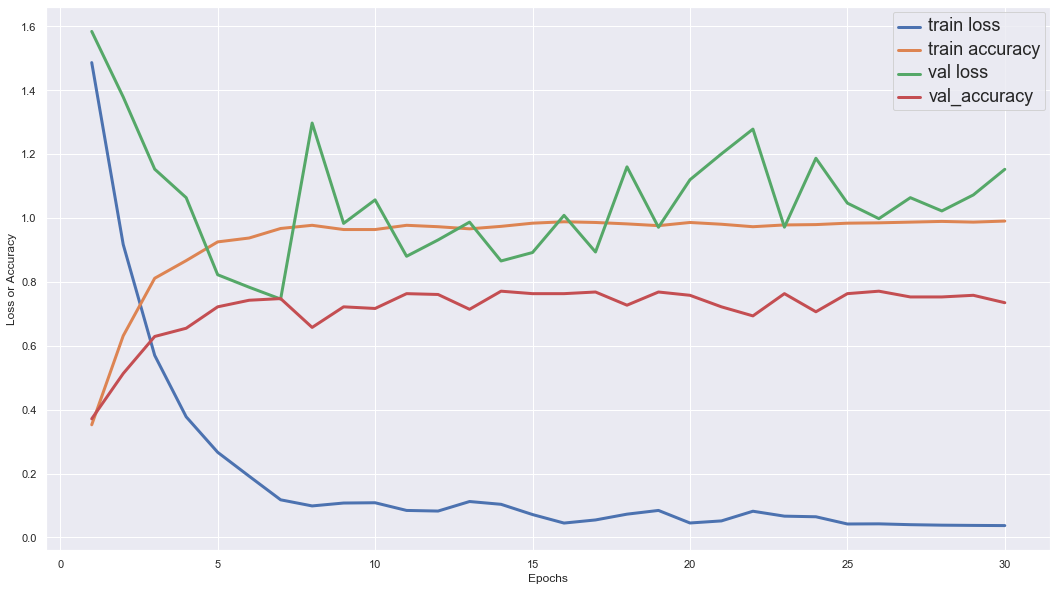

In [70]:
sns.set(font_scale=1)
f, ax = plt.subplots(1, 1, figsize=(18,10))
sns.lineplot(data=plot_df, x='epochs', y='loss', ax=ax, label='train loss', linewidth=3)
sns.lineplot(data=plot_df, x='epochs', y='accuracy', ax=ax, label='train accuracy', linewidth=3)
sns.lineplot(data=plot_df, x='epochs', y='val_loss', ax=ax, label='val loss', linewidth=3)
sns.lineplot(data=plot_df, x='epochs', y='val_accuracy', ax=ax, label='val_accuracy', linewidth=3)
ax.set_ylabel('Loss or Accuracy')
ax.set_xlabel('Epochs')
plt.setp(ax.get_legend().get_texts(), fontsize='18'); # for legend text

In [100]:

def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):

    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names,
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cmap='viridis')
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [101]:
# evaluate the network
print ( "[INFO] evaluating network..." )
predictions = model.predict(padded_test_sequences)
print (classification_report(testy.argmax(axis=1 ),
predictions.argmax(axis=1 ), target_names=types))

[INFO] evaluating network...
              precision    recall  f1-score   support

    Bearings       0.64      0.80      0.71        87
       Bolts       0.85      0.73      0.79        75
     Collets       0.87      0.74      0.80        62
     Springs       0.72      0.79      0.75        96
   Sprockets       0.70      0.56      0.62        68

    accuracy                           0.73       388
   macro avg       0.75      0.73      0.73       388
weighted avg       0.75      0.73      0.73       388



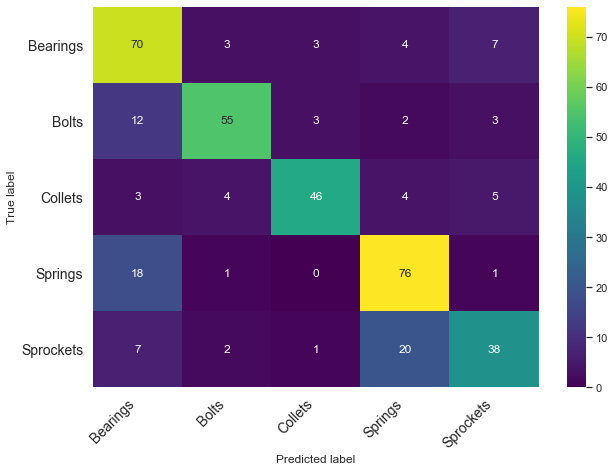

In [102]:
cm = confusion_matrix(testy.argmax(axis=1),
                      predictions.argmax(axis=1))
print_confusion_matrix(cm, types)

In [71]:
# save the model
save_path = r"C:\Users\mhasa\AppData\Roaming\Autodesk\Autodesk Fusion 360\MyScripts\PureFlask_3JS_server\flask_app\nlp_model"
model.save(f"{save_path}\\nlp_model_mcmaster.h5", overwrite=True)

In [72]:
embedding_layer = model.layers[0]
embedding_weights = embedding_layer.get_weights()[0]
print(embedding_weights.shape)

(1600, 16)


In [73]:
reverse_word_index = dict([(val, key)
                           for (key, val) in tokenizer.word_index.items()])

In [74]:
import io

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, vocab_size):
  word = reverse_word_index[word_num]
  embeddings = embedding_weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

In [75]:
# save my embedding matrix
out_e = io.open('embed_matrix.txt', 'w', encoding='utf-8')

for word_num in range(1, vocab_size):
  word = reverse_word_index[word_num]
  embeddings = embedding_weights[word_num]
  out_str = word + '\t' + '\t'.join([str(x) for x in embeddings]) + "\n"
  out_e.write(out_str)
out_e.close()

In [76]:
import pickle

# saving
with open(f'{save_path}//tokenizer_mcmaster.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [77]:
# loading the tokenizer
import pickle

with open(f'{save_path}//tokenizer_mcmaster.pickle', 'rb') as handle:
    loaded_tokenizer = pickle.load(handle)

In [78]:
loaded_model = load_model(f"{save_path}//nlp_model_mcmaster.h5")

In [97]:
sample_text = ["something that can be used to hold workpiece"]
sample_text_array = np.asarray(sample_text)

In [98]:
sample_text_sequence = loaded_tokenizer.texts_to_sequences(sample_text_array)
padded_sample_sequence = pad_sequences(sample_text_sequence, maxlen=max_length)
padded_sample_sequence

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   1,
         30,  47,  28,  38,   3, 108,  57]])

In [99]:
types = ['Bearings', 'Bolts', 'Collets', 'Springs', 'Sprockets']
pred = loaded_model.predict(padded_sample_sequence)
index = np.argmax(pred)
queried_part = types[int(index)]
print(f"Queried part is: {queried_part}")

Queried part is: Collets
